In [14]:
import os
import cv2
import argparse
import numpy as np
from PIL import Image
from gmflow_utils.flow_viz import save_vis_flow_tofile, flow_to_image, compute_color
import matplotlib.pyplot as plt

In [15]:
def lift(depth, camera_k):
    im_h, im_w = depth.shape[:2]
    u, v = np.arange(im_w), np.arange(im_h)
    uu, vv = np.meshgrid(v, u, indexing='ij')
    pixels = np.stack([vv.reshape(-1), uu.reshape(-1), np.ones(im_h*im_w)])

    # project pixels
    rays = np.linalg.inv(camera_k) @ pixels  # 3 x (im_h x im_w)
    points = rays.T.reshape(im_h, im_w, 3) * depth  # im_h x im_w x 3

    # Reshape for output
    pixels = pixels.T
    return pixels[:,:2], points.reshape(im_h*im_w, 3)

def transform_points(points, T):
    n_pts = points.shape[0]
    homo_points = np.concatenate([points, np.ones((n_pts, 1))], axis=1)
    transformed = (T @ homo_points.T).T
    transformed = transformed[:,:3]
    return transformed

def project(points, camera_k):
    points_T = points.T
    homo_points = (points_T / points_T[2])
    pixels = (camera_k @ homo_points).T
    return pixels[:,:2]

In [36]:
depth_dir = '/home/jiacheng/tmp/gmflow_gt_slow/depth/'
pose_dir = '/home/jiacheng/tmp/gmflow_gt_slow/pose'
raw_flow_dir = '/home/jiacheng/tmp/gmflow_gt_slow/raw_flow/'
depth_flist = os.listdir(depth_dir)
pose_flist = os.listdir(pose_dir)
raw_flow_flist = os.listdir(raw_flow_dir)
depth_flist.sort()
pose_flist.sort()
raw_flow_flist.sort()
camera_k = np.loadtxt('/home/jiacheng/tmp/gmflow_gt_slow/camera_k.txt')

i = 160
b_T_cam1 = np.loadtxt(os.path.join(pose_dir, pose_flist[i]))
b_T_cam2 = np.loadtxt(os.path.join(pose_dir, pose_flist[i+1]))
depth_1 = np.load(os.path.join(depth_dir, depth_flist[i])).astype('float')
depth_1 = depth_1 / 1e3

pixels_1, points_1 = lift(depth_1, camera_k)

cam2_T_cam1 = np.linalg.inv(b_T_cam2) @ b_T_cam1
points_2 = transform_points(points_1, cam2_T_cam1)
pixels_2 = project(points_2, camera_k)

depth_mask = (depth_1 == 0).reshape(depth_1.shape[0], depth_1.shape[1])
finger_mask = np.asarray(Image.open('/home/jiacheng/tmp/mask.png'))
finger_mask = finger_mask[:,:,0] > 0
mask = finger_mask | depth_mask

flow_gt = (pixels_2 - pixels_1).reshape(depth_1.shape[0], depth_1.shape[1], 2)
flow_gt[mask] = 0
flow_mag_gt = np.linalg.norm(flow_gt, axis=2)

flow_pred = np.load(os.path.join(raw_flow_dir, raw_flow_flist[i]))
flow_pred[mask] = 0
flow_mag_pred = np.linalg.norm(flow_pred, axis=2)

mag_diff = np.abs(flow_mag_pred - flow_mag_gt)

[[ 9.99999976e-01 -1.51019246e-04  1.60781782e-04  3.05322430e-03]
 [ 1.51165698e-04  9.99999573e-01 -9.11248286e-04 -5.97313507e-04]
 [-1.60644097e-04  9.11272568e-04  9.99999572e-01 -4.47966776e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] (480, 640, 2)


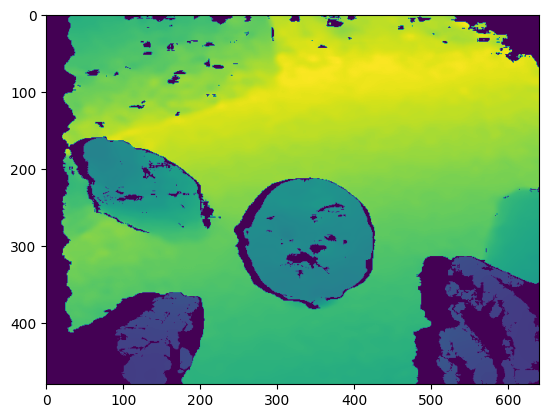

In [37]:
print(cam2_T_cam1, flow_pred.shape)
plt.imshow(depth_1)

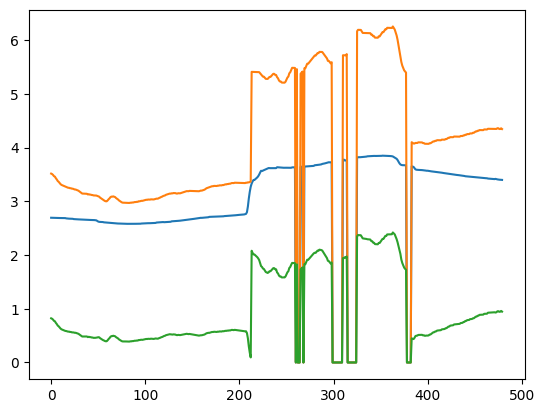

In [39]:
lines = np.stack([flow_mag_pred[:,350], flow_mag_gt[:,350], mag_diff[:,350]]).T
plt.plot(lines)